In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
import auth
import getpass

user  = getpass.getuser()
token = auth.get_valid_token()

In [25]:
import trino
import os
connection = trino.dbapi.connect(
    host=os.environ['PRESTO_HOST'],
    port=443,
    user=user,
    catalog="hive",
    schema="dwh_insider",
    http_scheme='https',
    auth=trino.auth.BasicAuthentication(user, token))

In [26]:
# Taking the claim information from the datalake
query = """
WITH claim_query as 
(
SELECT

       carrier_tracking_number
      , claim_shipment_number
      , sk_claim_report_date
      , aviailable_claim_amount_euro
      , net_claim_amount_euro
      , carrier_name
      , carrier_name_short
      , country_code 
      , sk_shipping_country as country
      , claimtype
      , cast(sk_month as int) as sk_month
      , SK_WEEK
      , claimsubtype
      , manual_refund_reason_name
      , claim_category
      , dd.ZIP
      , dd.city
      , TS_LAST_COT_EVENT
      , TS_LAST_CRT_EVENT
      , unplanned_return_flag 
      , reconditioned_claim_flag 
      , CASE WHEN chan.sk_cfa in (31, 26) THEN 'FashionStore'
             WHEN chan.sk_cfa = 28 THEN 'Lounge' END AS cfa -- 26 is empty for recent periods, it stands for zlash
      ,CASE WHEN carrier_name='n/a' THEN claimsubtype
            ELSE carrier_name END AS carrier
FROM
    dwh_confidential.f_clm_claim_shipments as fccs
LEFT JOIN
          dwh_insider.d_clm_carrier_liability as dccl
          ON dccl.sk_clm_carrier_liability = fccs.sk_clm_carrier_liability
LEFT JOIN
          dwh_insider.d_network_carriers as dnc
          ON dnc.sk_network_carrier = fccs.sk_network_carrier
LEFT JOIN
          dwh_insider.d_sf_carrier_claim_types as dscct
          ON dscct.sk_claim_type = fccs.sk_claim_type
LEFT JOIN
          dwh_insider.d_clm_claim_categories as dccc
          ON dccc.sk_claim_category = fccs.sk_claim_category
LEFT JOIN
          dwh_insider.d_manual_refund_reason AS dmrr
          ON dmrr.sk_manual_refund_reason = fccs.sk_manual_refund_reason
LEFT JOIN
          dwh_confidential.D_DESTINATIONS AS dd
          ON fccs.SK_DESTINATION = dd.SK_DESTINATION
LEFT JOIN
          dwh_insider.d_sales_channels AS chan
          ON fccs.sk_sales_channel = chan.sk_sales_channels 
LEFT JOIN 
          dwh_insider.d_date as d
          ON d.sk_date=fccs.sk_claim_report_date
          
WHERE  chan.sk_cfa in (31, 26, 28)
)
SELECT 
       COUNT(DISTINCT claim_shipment_number) as number_of_claims,
       SUM(aviailable_claim_amount_euro) as claims_amount ,
       country_code , 
       sk_month,
       carrier,
       ZIP,
       city
       
FROM claim_query
 WHERE 
   --  country_code='GB'
--       AND 
   claimtype='Delivery'
   
    AND 
     cfa = 'FashionStore'
      AND 
      sk_month Between 202201 AND 202212
GROUP BY 
         sk_month , 
         country_code,
         carrier,
         ZIP,
        city
         
   """
df = pd.read_sql_query(query, connection)
df  

/tmp/ipykernel_537/306403700.py:88: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


,number_of_claims,claims_amount,country_code,sk_month,carrier,ZIP,city
0,1,46.2400000,ES,202211,CELERITAS,50008,ZARAGOZA
1,1,103.0000000,DE,202201,HERMES,31535,Neustadt Am Rübenberge
2,4,224.8600000,FR,202206,COLIS PRIVÉ,30100,Ales
3,3,462.6300000,FR,202205,LA POSTE,74140,St Cergues
4,5,480.6000000,DE,202209,ZALANDO PREMIUM LOGISTICS,44795,Bochum
...,...,...,...,...,...,...,...
246645,1,141.6300000,FR,202209,CHRONOPOST,59700,Marcq en Baroeul
246646,1,5.4400000,NL,202202,BUDBEE,6274 NK,Reijmerstok
246647,1,71.6300000,FR,202202,COLIS PRIVÉ,78460,Chevreuse
246648,1,103.0000000,DE,202205,HERMES,79106,Freiburg Im Breisgau


In [27]:
df['claims_amount']=df['claims_amount'].astype(float)

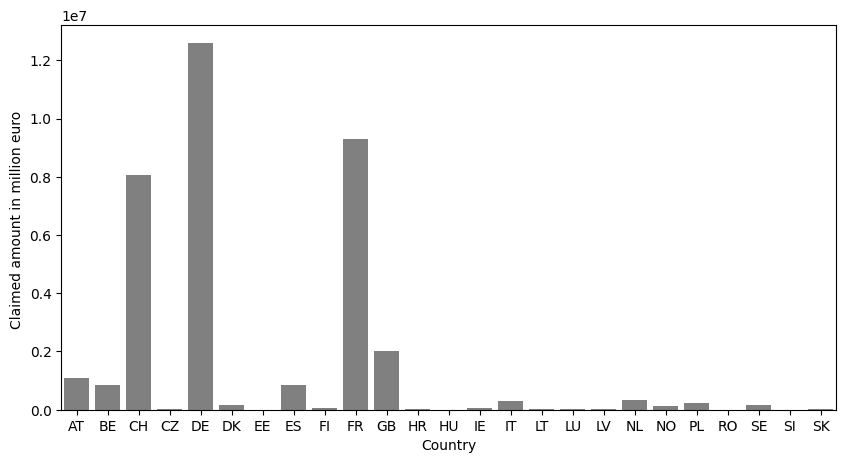

In [28]:
group_country=df.groupby(['country_code'], as_index=True)['claims_amount'].sum()
group_country=group_country.reset_index()
fig, ax = plt.subplots(figsize=(10,5))
ax=sns.barplot(data=group_country, x="country_code", y="claims_amount",color='gray')
ax.set_ylabel('Claimed amount in million euro ')    
ax.set_xlabel('Country')
plt.show()

In [29]:
group_country

,country_code,claims_amount
0,AT,1.073676e+06
1,BE,8.391182e+05
2,CH,8.075748e+06
3,CZ,3.913738e+04
4,DE,1.259157e+07
5,DK,1.489150e+05
6,EE,1.807880e+03
7,ES,8.500703e+05
8,FI,5.066751e+04
9,FR,9.292037e+06


In [21]:
group_country_uk=df[df['country_code']=='GB']
group_country_uk['carriers'] = group_country_uk.loc[:,('carrier')].apply(lambda x: 'Hermes' if x in ('HERMES','HMS')   else 'YODEL')
group_country_uk=group_country_uk.groupby(['sk_month','carriers'], as_index=True).agg({'claims_amount':sum,'number_of_claims':sum})
group_country_uk=group_country_uk.reset_index()

group_country_uk['carriers'] =group_country_uk['carriers'].str.upper()
group_country_uk

/tmp/ipykernel_537/2422056830.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_country_uk['carriers'] = group_country_uk.loc[:,('carrier')].apply(lambda x: 'Hermes' if x in ('HERMES','HMS')   else 'YODEL')


,sk_month,carriers,claims_amount,number_of_claims
0,202201,HERMES,184483.47,1739
1,202202,HERMES,170804.89,1031
2,202203,HERMES,195688.29,1319
3,202204,HERMES,174781.77,1290
4,202205,HERMES,125753.72,1076
5,202206,HERMES,162336.92,1337
6,202207,HERMES,114614.48,1188
7,202208,HERMES,84030.51,826
8,202209,HERMES,113042.18,900
9,202210,HERMES,177447.16,1480


In [17]:
group_country_uk.loc[:, ('carriers')]

0     HERMES
1     HERMES
2     HERMES
3     HERMES
4     HERMES
5     HERMES
6     HERMES
7     HERMES
8     HERMES
9     HERMES
10    HERMES
11     YODEL
12    HERMES
13     YODEL
Name: carriers, dtype: object

In [ ]:
group_country_uk['sk_month']=group_country_uk['sk_month'].astype(str)
fig, ax = plt.subplots(figsize=(10,5))

ax=sns.barplot(data=group_country_uk, x="sk_month", y="number_of_claims",palette=["orange", "gray"],hue='carriers',errorbar=None)
ax.set_ylabel('Number of Claims ')    
ax.set_xlabel('Month')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

In [ ]:
# Taking the claim information from the datalake
query = """
with ffsoi_base as (
        select

                        ffsoi.shipment_id, ffsoi.ts_est_delivery_from, ffsoi.ts_est_delivery_to,
                        ffsoi.sk_order_type, ffsoi.sk_logistic_provider, ffsoi.sk_order_date,
                        ffsoi.full_cancellation_flag, ffsoi.sk_selected_fulfill_service,
                        ffsoi.sk_delivery_type, ffsoi.sk_sales_channel, ffsoi.sk_destination,
                        ffsoi.sk_wmo_flag, ffsoi.shipment_has_ldd, ffsoi.sk_stock_location_id,
                        ffsoi.sk_carrier,

                        fccs.ts_first_delivery_attempt, fccs.sk_customer_delivery_date,
                        fccs.ts_customer_delivery,
                        fccs.lt_min_order_to_fda_wo_sun, fccs.lt_min_order_to_fda_wo_wend,
                        fccs.sk_delivery_cluster_wo_sun, fccs.is_prepayment_shipment,

                        fccs.is_delivered_too_early,
                        fccs.is_delivered_two_days_earlier,
                        fccs.is_delivered_a_day_earlier,
                        fccs.is_delivered_as_promised,
                        fccs.is_home_target,
                        fccs.is_pickup_point_target,
                        fccs.is_delivered_to_home,
                        fccs.is_delivered_to_pickup_point,

                        coalesce(ffsoi.sk_carrier, fccs.sk_carrier) as sk_carrier,
                        coalesce(ffsoi.sk_delivery_product, fccs.sk_delivery_product) as sk_delivery_product,

                        f_serv.fulfillment_service,
                        d_serv.service_name,
                        d_prod_serv.service_name as del_serv,
                        chan.sk_cfa,
                        country.destination_country,
                        logistic.logistic_provider_name,
                        logistic.logistic_provider,
                        stock.warehouse_name,
                        carr.carrier_description,
                        d_prod.sk_delivery_service,
                        d_prod.sk_delivery_carrier,
                        case when chan.sk_cfa in (31, 26) then 'FS'
                             when chan.sk_cfa = 28 then 'Lounge' end as cfa -- 26 is empty for recent periods, it stands for zlash


        from

                      (select shipment_id,
                              min(ts_est_delivery_from) as ts_est_delivery_from,
                              min(ts_est_delivery_to) as ts_est_delivery_to,
                              max(sk_order_type) as sk_order_type,
                              max(sk_logistic_provider) as sk_logistic_provider,
                              max(sk_order_date) as sk_order_date,
                              max(full_cancellation_flag) as full_cancellation_flag,
                              max(sk_selected_fulfill_service) as sk_selected_fulfill_service,
                              max(sk_delivery_type) as sk_delivery_type,
                              max(sk_sales_channel) as sk_sales_channel,
                              max(sk_destination) as sk_destination,
                              max(sk_wmo_flag) as sk_wmo_flag,
                              max(sk_stock_location_id) as sk_stock_location_id,
                              max(is_long_distance_item) as shipment_has_ldd,
                              max(sk_carrier) as sk_carrier,
                              max(sk_delivery_product) as sk_delivery_product
                      from dwh_confidential.f_fos_shipment_order_items
                      where sk_order_date between  20220101 and 20221231
                      group by shipment_id ) as ffsoi

                      -- For calculated lead times [sk_delivery_cluster_wo_sun, lt_min_order_to_fda_wo_sun,
                      -- lt_min_order_to_fda_wo_wend]
                      left join (select shipment_id, 
                                        max(ts_first_delivery_attempt) as ts_first_delivery_attempt,
                                        max(sk_first_delivery_attempt_date) as sk_first_delivery_attempt_date,
                                        max(ts_customer_delivery) as ts_customer_delivery,
                                        max(sk_customer_delivery_date) as sk_customer_delivery_date,
                                        max(lt_min_order_to_fda_wo_sun) as lt_min_order_to_fda_wo_sun,
                                        max(lt_min_order_to_fda_wo_wend) as lt_min_order_to_fda_wo_wend,
                                        max(sk_delivery_cluster_wo_sun) as sk_delivery_cluster_wo_sun,
                                        max(sk_carrier) as sk_carrier,
                                        max(sk_delivery_product) as sk_delivery_product,
                                        max(is_delivered_too_early) as is_delivered_too_early,
                                        max(is_delivered_two_days_earlier) as is_delivered_two_days_earlier,
                                        max(is_delivered_a_day_earlier) as is_delivered_a_day_earlier,
                                        max(is_delivered_as_promised) as is_delivered_as_promised,
                                        max(is_prepayment_shipment) as is_prepayment_shipment,
                                        max(is_home_target) as is_home_target,
                                        max(is_pickup_point_target) as is_pickup_point_target,
                                        max(is_delivered_to_home) as is_delivered_to_home,
                                        max(is_delivered_to_pickup_point) as is_delivered_to_pickup_point
                                 from dwh_confidential.f_cot_carrier_shipments
                                 where sk_min_order_created_date between 20220101 and 20221231
                                 group by shipment_id ) as fccs
                                 on ffsoi.shipment_id = fccs.shipment_id

                      -- For delivery service [sk_delivery_carrier]
                      left join dwh_insider.d_delivery_products d_prod
                                on coalesce(ffsoi.sk_delivery_product, fccs.sk_delivery_product) = d_prod.sk_delivery_product

                      -- for carrier name [carrier_name]
                      left join dwh_insider.d_delivery_carriers carr
                                on d_prod.sk_delivery_carrier = carr.sk_delivery_carrier

                      -- For selected fulfillment service [fulfillment_service]
                      left join dwh_insider.d_shp_fulfillment_services f_serv
                                on ffsoi.sk_selected_fulfill_service = f_serv.sk_fulfillment_service

                      -- For delivery service [service_name]
                      left join dwh_insider.d_delivery_services d_serv
                                on ffsoi.sk_delivery_type = d_serv.sk_delivery_service

                      -- For delivery service [service_name]
                      left join dwh_insider.d_delivery_services d_prod_serv
                                on d_prod.sk_delivery_service = d_prod_serv.sk_delivery_service

                      -- For filtering for shop [sk_cfa]
                      left join dwh_insider.d_sales_channels chan
                                on ffsoi.sk_sales_channel = chan.sk_sales_channels

                      -- For getting destination country [country_code]
                      left join (select sk_destination, max(sk_shipping_country) as sk_country
                                 from dwh_confidential.d_destinations
                                 group by 1) as dest
                                on ffsoi.sk_destination = dest.sk_destination

                      -- For filtering Zalando fulfillment [fulfillment_type, warehouse_name]
                      left join dwh_insider.d_stock_location_bp as stock
                                on ffsoi.sk_stock_location_id = stock.sk_stock_location

                      -- For getting destination country [destination_country]
                      left join (select sk_country, country_name_short_en as destination_country
                                 from dwh_confidential.d_country
                                 group by 1, 2) as country
                                on dest.sk_country = country.sk_country

                      left join dwh_insider.d_logistic_provider logistic
                                on ffsoi.sk_logistic_provider = logistic.sk_logistic_provider

            where cast(date_format(ts_est_delivery_to, '%Y%m%d') as integer) between 20220101 and 20221231

             and ffsoi.sk_order_type in (5)
             
             and ffsoi.sk_stock_location_id in (130, 116, 331, 36, 377, 205, 135, 5319099, 167178576, 337994408, 167178575, 89888100, 194682468, 194685072, 194683969)
             and ffsoi.full_cancellation_flag = 0
           
             and chan.sk_cfa in (31, 26, 28)
             and fccs.is_prepayment_shipment in (0)
           )
           SELECT  COUNT(DISTINCT shipment_id) as number_of_shipmets
                 
                  ,destination_country
                  ,carrier_description 
                  , cast(sk_month as varchar) as sk_month
           FROM ffsoi_base
           LEFT JOIN 
          dwh_insider.d_date as d
          ON d.sk_date = ffsoi_base.sk_customer_delivery_date
           WHERE destination_country='United Kingdom'
                   AND cfa = 'FS'
                   AND sk_month between 202201 and 202212
           GROUP BY  destination_country
                    ,carrier_description
                     , sk_month
         
   """
shipments = pd.read_sql_query(query, connection)
shipments 

In [ ]:

df3=pd.merge( group_country_uk,shipments ,left_on=["sk_month","carriers"], right_on=["sk_month","carrier_description"], how='left' )
df3=df3[['sk_month','carriers','claims_amount','number_of_claims','number_of_shipmets']]
df3['claims_rate']=(df3['number_of_claims']/df3['number_of_shipmets'])*100
df3

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax=sns.lineplot(data=df3, x="sk_month", y="claims_rate",hue='carriers',errorbar=None,palette=["orange", "gray"])
ax.set_ylabel('Claims rate')    
ax.set_xlabel('Month')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0) 
    # label points on the plot
for x, y in zip(df3['sk_month'], df3['claims_rate']):
    plt.text(x = x, y = y,s='{0:.2f}'.format(y),color = 'black')
plt.show()